Импортируем библеотеки для работы с данными и считаем данные.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv("df_train.csv")
test = pd.read_csv("df_test.csv")
Y_binar = data["class"]
df = data.drop(["author", "class", "Unnamed: 0"], axis=1)

In [3]:
data[data["class"] == 1]

,Unnamed: 0,author,class,",",.,и,в,социальный,на,:,...,Ялом,ярко-красный,ярлык,Ярославский,яростный,ясно,ясность,яхта,ящичка,ящичный
150,179,gigachat,1,11.2,6.4,6.8,3.0,2.4,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
151,180,gigachat,1,10.0,6.6,7.8,1.8,5.0,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
152,181,gigachat,1,9.2,6.2,6.0,2.8,7.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
153,182,gigachat,1,8.2,5.8,7.8,1.2,3.4,1.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
154,183,gigachat,1,8.2,6.8,7.8,2.0,4.4,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,694,yandexgpt,1,7.4,4.8,3.8,3.0,0.2,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
597,695,yandexgpt,1,7.0,4.8,4.8,2.4,2.0,0.4,1.6,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
598,697,yandexgpt,1,8.6,5.2,4.8,3.8,1.2,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
599,699,yandexgpt,1,6.6,7.0,3.2,3.0,1.0,1.0,1.2,...,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


Построим первую модель, простой метод опорных векторов, который опираеться на 50 лучших признаков, которые мы отберем при помощи дисперсионного анализа

In [4]:
selector = VarianceThreshold()
df_new = selector.fit_transform(X=df)
selector_binar = SelectKBest(f_classif, k=50)
X_binar = selector_binar.fit_transform(df_new, Y_binar)
selected_ind_binar = selector_binar.get_support(indices=True)
print(list(df.columns[selected_ind_binar]))

['и', 'социальный', ':', 'общество', 'мочь', '"', 'как', 'который', ')', '(', 'не', 'различный', 'процесс', 'структура', '–', 'то', 'развитие', 'также', 'изменение', 'например', 'роль', 'взаимодействие', 'влиять', 'культурный', 'но', 'важный', 'включать', 'влияние', 'можно', 'тот', 'только', 'понимание', 'все', 'ключевой', 'аспект', 'же', 'первый', 'взаимодействовать', 'включая', 'играть', 'помогать', 'контекст', 'иной', 'самый', 'сам', 'еще', 'нужный', 'поэтому', 'говорить', 'лишь']


Посмотрим какие признаки были отобраны

Разделим выборку на тренировочную и валидационную

In [5]:
X_binar_train, X_binar_val, Y_binar_train, Y_binar_val = train_test_split(X_binar, Y_binar,
                                                                          test_size=0.33, shuffle=True, stratify=Y_binar)

Наш pypeline состоит из нормировки и машин опорных векторов, гиперпарамметры такие как C, gamma и свободный коэфицент будем подбирать при помощи кросс валидации.

In [6]:
pipeline = Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability=True))])
params = {"svm__C": np.logspace(-3, 3, num=7, base=10.)}
gs = GridSearchCV(pipeline, params)
gs.fit(X_binar_train, Y_binar_train)
gs.best_params_

{'svm__C': 1.0}

Оценим нашу модель на валидационной выборке при помощи точности предсказаний и площадью под roc кривой

In [7]:
clf = gs.best_estimator_
print(accuracy_score(clf.predict(X_binar_val), Y_binar_val))
print(roc_auc_score(clf.predict(X_binar_val), Y_binar_val))

0.9899497487437185
0.9895833333333333


Построим roc кривую

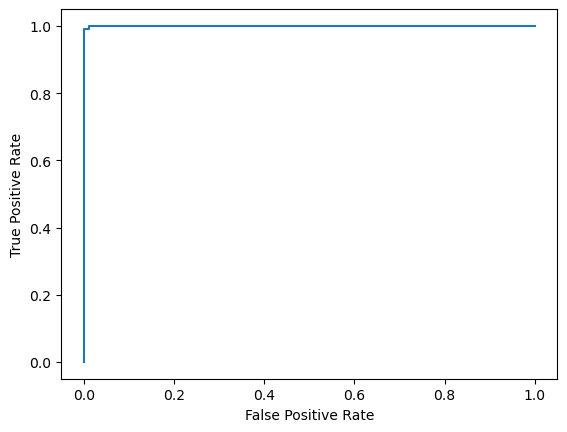

In [8]:
Y_pred_prob = clf.predict_proba(X_binar_val)[::, 1]
fpr, tpr, _ = roc_curve(Y_binar_val, Y_pred_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Посмотрим на матрицу ошибок и f1_score

In [9]:
print(confusion_matrix(clf.predict(X_binar_val), Y_binar_val))

[[ 94   2]
 [  0 103]]


In [10]:
Y_pred_test_binar = clf.predict(np.array(test[df.columns[selected_ind_binar]]))
print(Y_pred_test_binar)

[0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0]


In [11]:
ans = pd.read_csv("df_test_otvety.csv")

In [12]:
print(accuracy_score(Y_pred_test_binar, ans["class"]))

0.99
